### Load data

In [1]:
import common
import pandas as pd
data_df, lects_df = common.load_lexirumah()
display(data_df.head())
display(lects_df.head())




Loading data...
Loaded data.


,ID,Lect_ID,Concept_ID,Form_according_to_Source,Form,Local_Orthography,Segments,Comment,Source
0,abui1241-fuime-sky-1,abui1241-fuime,sky,adi,adi,adi,"[a, d, i]",None,[schapper10]
1,abui1241-fuime-sun-1,abui1241-fuime,sun,wari,wari,wari,"[w, a, r, i]",None,[schapper10]
2,abui1241-fuime-moon-1,abui1241-fuime,moon,ije,ije,iye,"[i, j, e]",None,[schapper10]
3,abui1241-fuime-star-1,abui1241-fuime,star,fɪri,fɪri,firi,"[f, ɪ, r, i]",None,[schapper10]
4,abui1241-fuime-night-1,abui1241-fuime,night,tuŋtama,tuŋtama,tungtama,"[t, u, ŋ, t, a, m, a]",None,[schapper10]


,ID,Name,Family,Latitude,Longitude,Region,Glottocode,Iso,Culture,Description,Orthography,Comment,Macroarea
0,abui1241-fuime,"Abui, Fuimelang",Timor-Alor-Pantar,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
1,abui1241-petle,"Abui, Petleng",Timor-Alor-Pantar,-8.2144,124.593,"Kecamatan Teluk Mutiara, Kabupaten Alor, East ...",abui1241,abz,None,None,"[p/general, p/abui1241-petle]",None,Papunesia
2,abui1241-takal,"Abui, Takalelang",Timor-Alor-Pantar,-8.1887,124.6264,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,abui,None,"[p/general, p/abui1241-takal]",None,Papunesia
3,abui1241-ulaga,"Abui, Ulaga",Timor-Alor-Pantar,-8.403792,124.623702,"Kecamatan Alor Barat Daya, Kabupaten Alor, Eas...",abui1241,abz,None,None,"[p/general, p/abui1241-ulaga]",None,Papunesia
4,adan1251-lawah,"Adang, Lawahing",Timor-Alor-Pantar,-8.2109,124.4272,"Kecamatan Alor Barat Laut, Kabupaten Alor, Eas...",adan1251,adn,None,None,"[p/general, p/adan1251-lawah]",None,Papunesia


### Select and combine data

In [2]:
#lects_df = lects_df[["ID", "Name", "Family", "Region", "Latitude", "Longitude"]]
# Filter out proto-languages
lects_df = lects_df[~lects_df["Name"].str.startswith("proto-")]
lects_alorese = lects_df[lects_df["Name"].str.startswith("Alorese")]
# Four Western Lamaholot languages close to Alorese
#lects_lamaholot_related = lects_df[lects_df["Name"].str.contains(
#    "Lamalera|Lewotobi|Lewoingu|Lewolema", case=False, regex=True)]
lects_western_lamaholot = lects_df[lects_df["Iso"].isin(["adr", "lmr", "slp", "ila", "lwt"])]
# Flores-Lembata family, but with preceding WL varieties excluded (and Alorese excluded)
lects_flores_lembata = lects_df[(lects_df["ID"].str.startswith("lama") | lects_df["ID"].str.startswith("sika") | lects_df["ID"].str.startswith("keda")) & ~lects_df.index.isin(lects_western_lamaholot.index)]
# Timor-Alor-Pantar languages, but only Alor-Pantar languages, spoken adjacent to Alorese
lects_alor_pantar = lects_df[lects_df["Family"].str.startswith("Timor-Alor-Pantar") & lects_df["Region"].str.contains("Alor|Pantar", case=False, regex=True)]
# Other Timor-Alor-Pantor languages, spoken on Timor (and small island Kisar)
lects_timor = lects_df[lects_df["Family"].str.startswith("Timor-Alor-Pantar") & ~lects_df.index.isin(lects_alor_pantar.index)]
lects_selected_df = pd.concat([lects_alorese, lects_western_lamaholot, lects_flores_lembata, lects_alor_pantar, lects_timor])

# Join data with lect name from lects table
# This order (first select lects, then merge) fastest
data_langs_df = data_df[data_df["Lect_ID"].isin(lects_selected_df["ID"])]
data_langs_df = data_langs_df.rename(columns={"ID":"Form_ID"})
data_merged_df = data_langs_df.merge(lects_df, how="left", left_on="Lect_ID", right_on="ID")
data_merged_df = data_merged_df.drop("ID", axis=1)
display(data_merged_df.head())


,Form_ID,Lect_ID,Concept_ID,Form_according_to_Source,Form,Local_Orthography,Segments,Comment_x,Source,Name,...,Latitude,Longitude,Region,Glottocode,Iso,Culture,Description,Orthography,Comment_y,Macroarea
0,abui1241-fuime-sky-1,abui1241-fuime,sky,adi,adi,adi,"[a, d, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
1,abui1241-fuime-sun-1,abui1241-fuime,sun,wari,wari,wari,"[w, a, r, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
2,abui1241-fuime-moon-1,abui1241-fuime,moon,ije,ije,iye,"[i, j, e]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
3,abui1241-fuime-star-1,abui1241-fuime,star,fɪri,fɪri,firi,"[f, ɪ, r, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
4,abui1241-fuime-night-1,abui1241-fuime,night,tuŋtama,tuŋtama,tungtama,"[t, u, ŋ, t, a, m, a]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia


### Compute phoneme distributions & compute feature matrix per language

In [3]:
#display(data_merged_df[data_merged_df["Lect_ID"]=="alor1247-baran"])
CHARACTER_SEGMENTATION = False
if CHARACTER_SEGMENTATION:
    # perform per-character segmentation
    data_merged_df["Segments_char"] = data_merged_df["Form"].apply(list) # lambda x : [el for el in x if el!="_"]
    segments_col = "Segments_char"
    display(data_merged_df[["Segments", "Segments_char"]].head(50))
else:
    # Use segmentation from dataset (clustering some combinations together)
    segments_col = "Segments"

data_grouped_lang = data_merged_df.groupby("Lect_ID")
data_agg = data_grouped_lang.aggregate({segments_col:list, "Name": "first", "Family": "first", "Latitude": "first", "Longitude":"first"})
# data_agg["phone_prob"] = data_agg[segments_col].apply(common.phone_prob)
# data_agg["biphone_prob"] = data_agg[segments_col].apply(common.biphone_prob)
# data_agg["phone_prob_existence"] = data_agg[segments_col].apply(common.phone_prob_existence)
# data_agg["biphone_prob_existence"] = data_agg[segments_col].apply(common.biphone_prob_existence)
# display(data_agg.head())

# Effect now is:
# -1 for available biphone,
# -None for combination not available, None for combination and both constitutents not available
# => None replaced by 0
# What Macklin-Cordes does:
# - 1 for available biphone
# - 0 for combination not available, if constituents are available
# - None for combination not available, if constituents not available
phone_prob_matrix = common.create_matrix(data_agg, segments_col, common.phone_prob, "phone_prob")
phone_prob_boundaries_matrix = common.create_matrix(data_agg, segments_col, common.phone_prob_boundaries, "phone_prob_boundaries")
biphone_prob_matrix = common.create_matrix(data_agg, segments_col, common.biphone_prob, "biphone_prob")
phone_prob_existence_matrix = common.create_matrix(data_agg, segments_col, common.phone_prob_existence, "phone_prob_existence")
biphone_prob_existence_matrix = common.create_matrix(data_agg, segments_col, common.biphone_prob_existence, "biphone_prob_existence")
display(phone_prob_matrix.head())
display(phone_prob_boundaries_matrix.head())
display(biphone_prob_matrix.head())
display(phone_prob_existence_matrix.head())
display(biphone_prob_existence_matrix.head())


,ɜ,t̪,j,bv,ʔ,æ,uː,dː,sː,i,...,q,o,ts,pʰ,pː,h,ɞ,ɤ̃,ẽː,ɤː
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,NaN,NaN,0.0169154,NaN,NaN,NaN,0.000497512,NaN,NaN,0.108955,...,NaN,0.0353234,NaN,NaN,NaN,0.0223881,NaN,NaN,NaN,NaN
abui1241-papun,NaN,NaN,0.0194076,NaN,0.0020429,NaN,0.00868233,NaN,NaN,0.0020429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-petle,NaN,NaN,0.0278884,NaN,NaN,NaN,0.0059761,NaN,NaN,0.105578,...,NaN,0.0358566,NaN,NaN,NaN,0.0179283,NaN,NaN,NaN,NaN
abui1241-takal,0.000239521,NaN,0.0258683,NaN,0.000958084,NaN,0.00263473,NaN,NaN,0.0797605,...,0.034012,0.00766467,NaN,NaN,NaN,0.0364072,0.000479042,NaN,NaN,NaN
abui1241-ulaga,NaN,NaN,0.00439024,NaN,0.000243902,NaN,0.00292683,NaN,NaN,0.0958537,...,0.000731707,0.0292683,NaN,NaN,NaN,0.000243902,NaN,NaN,NaN,NaN


,ɜ,t̪,j,bv,ʔ,æ,uː,dː,sː,i,...,q,o,ts,pʰ,pː,h,ɞ,ɤ̃,ẽː,ɤː
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,NaN,NaN,0.0125276,NaN,NaN,NaN,0.00036846,NaN,NaN,0.0806927,...,NaN,0.0261606,NaN,NaN,NaN,0.0165807,NaN,NaN,NaN,NaN
abui1241-papun,NaN,NaN,0.0142965,NaN,0.00150489,NaN,0.00639579,NaN,NaN,0.00150489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-petle,NaN,NaN,0.0195531,NaN,NaN,NaN,0.00418994,NaN,NaN,0.0740223,...,NaN,0.0251397,NaN,NaN,NaN,0.0125698,NaN,NaN,NaN,NaN
abui1241-takal,0.000184196,NaN,0.0198932,NaN,0.000736784,NaN,0.00202616,NaN,NaN,0.0613373,...,0.0261558,0.00589427,NaN,NaN,NaN,0.0279978,0.000368392,NaN,NaN,NaN
abui1241-ulaga,NaN,NaN,0.00328587,NaN,0.000182548,NaN,0.00219058,NaN,NaN,0.0717415,...,0.000547645,0.0219058,NaN,NaN,NaN,0.000182548,NaN,NaN,NaN,NaN


,_,dʒ,h,æ,ʔ,h,oː,ɸ,kʷ,ə,...,<,t,a,f,m,wː,i,u,j,õ
,kʷ,o,ɜ,v,m,p,h,e,ə,tʃ,...,kʷ,ɜ,t,l,d,a,sː,bː,oː,h
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0105843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-papun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-petle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00492611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-takal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000208247,NaN,NaN,NaN,NaN,NaN,0.000208247,NaN
abui1241-ulaga,NaN,0.000835247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00981416,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,ɜ,t̪,j,bv,ʔ,æ,uː,dː,sː,i,...,q,o,ts,pʰ,pː,h,ɞ,ɤ̃,ẽː,ɤː
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,1,...,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
abui1241-papun,NaN,NaN,1,NaN,1,NaN,1,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-petle,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,1,...,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
abui1241-takal,1,NaN,1,NaN,1,NaN,1,NaN,NaN,1,...,1,1,NaN,NaN,NaN,1,1,NaN,NaN,NaN
abui1241-ulaga,NaN,NaN,1,NaN,1,NaN,1,NaN,NaN,1,...,1,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN


,_,dʒ,h,æ,ʔ,h,oː,ɸ,kʷ,ə,...,<,t,a,f,m,wː,i,u,j,õ
,kʷ,o,ɜ,v,m,p,h,e,ə,tʃ,...,kʷ,ɜ,t,l,d,a,sː,bː,oː,h
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-papun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-petle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-takal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN
abui1241-ulaga,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

# Divide MultiIndex biphone dataframe by phone dataframe
# Vectorized? How to handle division by zero? Keep NaNs? denominator is 0.0 -> numerator is 0.0. Thus keep 0.0 for total
# https://stackoverflow.com/questions/45128523/pandas-multiindex-how-to-select-second-level-when-using-columns


biphone_transition_matrix = pd.DataFrame(columns = biphone_prob_matrix.columns, index=biphone_prob_matrix.index)
for x,y in biphone_prob_matrix.columns:
    biphone_transition_matrix[x,y] = biphone_prob_matrix[x,y] / phone_prob_boundaries_matrix[x]
    biphone_transition_matrix[f"bw_{x}",f"bw_{y}"] = biphone_prob_matrix[x,y] / phone_prob_boundaries_matrix[y]
#     print("biphone")
#     print(biphone_prob_matrix[x,y])
#     print("phone bound")
#     print(phone_prob_boundaries_matrix[x])
#     print("transition")
#     print(biphone_transition_matrix[x,y])
display(biphone_transition_matrix)

,_,dʒ,h,æ,ʔ,h,oː,ɸ,kʷ,ə,...,bw_<,bw_t,bw_a,bw_f,bw_m,bw_wː,bw_i,bw_u,bw_j,bw_õ
,kʷ,o,ɜ,v,m,p,h,e,ə,tʃ,...,bw_kʷ,bw_ɜ,bw_t,bw_l,bw_d,bw_a,bw_sː,bw_bː,bw_oː,bw_h
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.19279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-papun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-petle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.135657,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-takal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00403775,NaN,NaN,NaN,NaN,NaN,0.0513896,NaN
abui1241-ulaga,NaN,0.111597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.210008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
teiw1235-adiab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.23012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
teiw1235-nule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.240661,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Perform dimensionality reduction

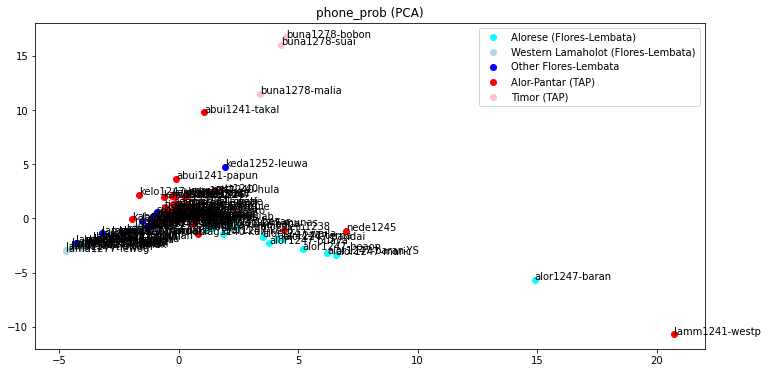

Loadings positive x:


kː    0.231727
nː    0.229743
tː    0.229180
bː    0.228419
mː    0.224324
pː    0.216608
lː    0.210351
dː    0.201428
gː    0.179173
sː    0.164911
Name: PC1, dtype: float64

Loadings negative x:


o     -0.155826
ã    -0.145686
ə     -0.142888
õ    -0.140334
ũ    -0.136783
ẽ    -0.123282
ĩ    -0.110461
ãː   -0.099997
e     -0.096619
ũː   -0.096095
Name: PC1, dtype: float64

Loadings positive y:


tʰ    0.216343
kʰ    0.214205
pʰ    0.213825
z     0.202750
lˑ    0.200249
aˑ    0.200249
k̚    0.200249
iˑ    0.200249
ts    0.184010
tʃ    0.183000
Name: PC2, dtype: float64

Loadings negative y:


p    -0.147324
kː   -0.122875
e    -0.122514
bː   -0.121540
nː   -0.118896
pː   -0.116329
tː   -0.115700
lː   -0.114253
mː   -0.112910
a    -0.110897
Name: PC2, dtype: float64

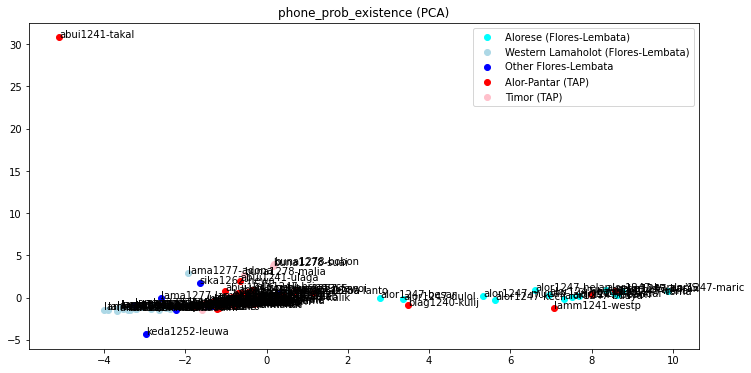

Loadings positive x:


nː    0.261316
bː    0.260438
pː    0.256570
kː    0.255466
rː    0.252140
lː    0.249344
mː    0.247299
dː    0.242461
tː    0.242013
gː    0.190871
Name: PC1, dtype: float64

Loadings negative x:


õ    -0.135218
ẽ    -0.130242
ã    -0.113607
ɲ     -0.102439
oː    -0.100256
ũ    -0.097368
ãː   -0.097266
ə̃    -0.081075
ĩ    -0.075816
ũː   -0.072321
Name: PC1, dtype: float64

Loadings positive y:


ä     0.289685
ɞ      0.289685
e̞     0.289685
ɘ      0.289685
ɐ      0.289685
e̞ː    0.289685
ɪ̈     0.289685
aː̈    0.289685
ü     0.289685
tʰ     0.176848
Name: PC2, dtype: float64

Loadings negative y:


õ    -0.051548
ẽ    -0.047826
ũ    -0.044118
ɛ̘    -0.040421
i̘    -0.040421
u̘    -0.040421
ɔ̘    -0.040421
æ̘    -0.040421
a̘    -0.040421
ãː   -0.039437
Name: PC2, dtype: float64

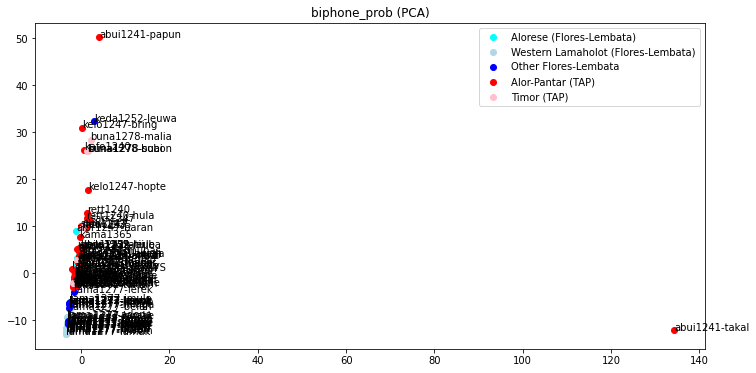

Loadings positive x:


f    aː̈    0.074488
e̞   b      0.074488
ʋ    e̞     0.074488
e̞   d      0.074488
     r      0.074488
ä   s      0.074488
m    j      0.074488
q    ɔ      0.074488
aː̈  t      0.074488
     ŋ      0.074488
Name: PC1, dtype: float64

Loadings negative x:


r  a   -0.021399
m  a   -0.021195
a  t   -0.020595
   >   -0.018867
b  a   -0.018596
l  e   -0.018031
n  a   -0.017462
m  e   -0.016606
e  >   -0.016511
b  e   -0.016433
Name: PC1, dtype: float64

Loadings positive y:


ɛ  s     0.063927
   g     0.061319
   n     0.060856
   l     0.060821
m  ɛ     0.060027
b  ɛ     0.059269
t  ɛ     0.059268
ɛ  b     0.056284
ɑ  k     0.055852
g  iː    0.055125
Name: PC2, dtype: float64

Loadings negative y:


e  >   -0.057155
p  e   -0.056833
o  >   -0.054397
p  i   -0.053920
<  p   -0.053036
m  e   -0.052887
b  e   -0.052830
   ə   -0.052274
ŋ  e   -0.050586
e  l   -0.050368
Name: PC2, dtype: float64

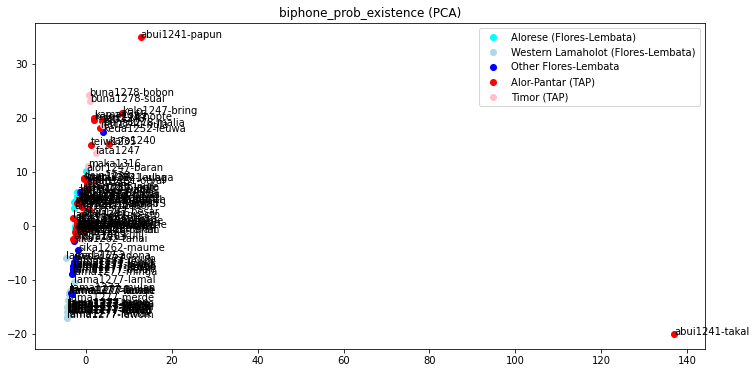

Loadings positive x:


q   ɔ      0.071078
l   ä     0.071078
ä  ʔ      0.071078
q   ä     0.071078
ä  t      0.071078
q   d      0.071078
ɲ   ä     0.071078
q   ɑ      0.071078
j   aː̈    0.071078
ɞ   ɪ      0.071078
Name: PC1, dtype: float64

Loadings negative x:


a  r   -0.071078
<  a   -0.071078
m  a   -0.053657
a  n   -0.053657
   l   -0.047890
t  a   -0.047890
k  a   -0.047890
l  a   -0.045671
a  m   -0.043112
r  a   -0.043112
Name: PC1, dtype: float64

Loadings positive y:


r  ɛ    0.059931
t  ɛ    0.058924
ɛ  l    0.058553
_  s    0.058254
b  ɛ    0.057906
n  ɛ    0.057769
l  ɛ    0.056667
ɛ  k    0.055656
   t    0.055612
   >    0.055459
Name: PC2, dtype: float64

Loadings negative y:


l   ã   -0.062018
ã  >    -0.060717
n   ã   -0.059767
r   õ   -0.059626
õ  >    -0.058869
k   ã   -0.058433
ŋ   e    -0.057718
w   ã   -0.057612
r   ã   -0.057427
ʔ   ã   -0.056813
Name: PC2, dtype: float64

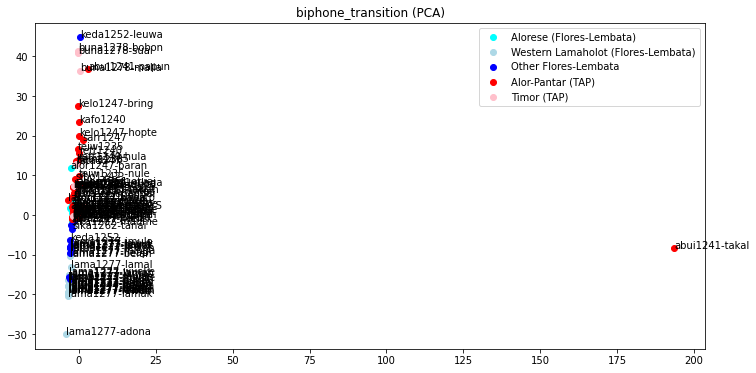

Loadings positive x:


aː̈     q         0.052158
bw_ä   bw_k      0.052158
aː̈     _         0.052158
bw_aː̈  bw_n      0.052158
aː̈     >         0.052158
bw_l    bw_aː̈    0.052158
bw_k    bw_aː̈    0.052158
bw_ä   bw_j      0.052158
aː̈     m         0.052158
k       aː̈       0.052158
Name: PC1, dtype: float64

Loadings negative x:


bw_m  bw_a   -0.020703
m     a      -0.015434
bw_l  bw_a   -0.015112
b     a      -0.014783
r     a      -0.014770
bw_a  bw_t   -0.014650
n     a      -0.014335
bw_t  bw_a   -0.013915
bw_r  bw_a   -0.013678
a     m      -0.013409
Name: PC1, dtype: float64

Loadings positive y:


bw_ɛ  bw_n    0.049574
      bw_l    0.046329
t     ɛ       0.045407
bw_ɛ  bw_k    0.044163
bw_ɔ  bw_k    0.044005
bw_l  bw_>    0.043715
l     >       0.043647
bw_ɔ  bw_l    0.043465
m     ɛ       0.042708
n     _       0.042487
Name: PC2, dtype: float64

Loadings negative y:


bw_e  bw_>   -0.046304
õ    >      -0.045752
l     o      -0.045599
bw_e  bw_l   -0.045505
a     o      -0.045490
bw_ŋ  bw_e   -0.045290
bw_ə  bw_r   -0.045267
bw_p  bw_i   -0.045205
ã    >      -0.045147
bw_o  bw_>   -0.045121
Name: PC2, dtype: float64

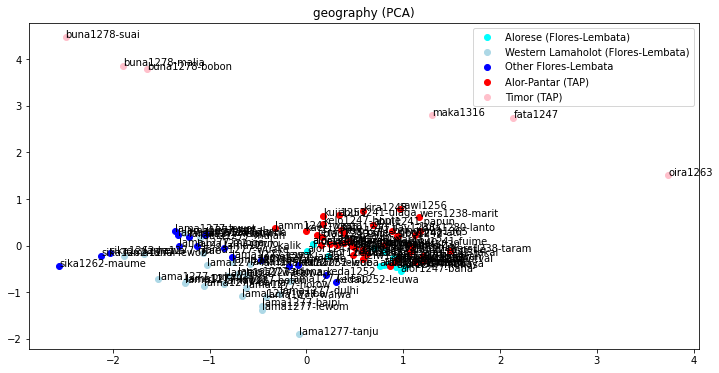

Loadings positive x:


Latitude     0.707107
Longitude    0.707107
Name: PC1, dtype: float64

Loadings negative x:


Longitude    0.707107
Latitude     0.707107
Name: PC1, dtype: float64

Loadings positive y:


Longitude    0.707107
Latitude    -0.707107
Name: PC2, dtype: float64

Loadings negative y:


Latitude    -0.707107
Longitude    0.707107
Name: PC2, dtype: float64

AttributeError: 'list' object has no attribute 'fillna'

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

PLOT_LABELS = True

# TODO: Biphone prob with transition probabilities

# Define language groups for plots
language_groups = {"Alorese (Flores-Lembata)": {"color": "cyan", "lects": lects_alorese["ID"]},
                   "Western Lamaholot (Flores-Lembata)": {"color": "lightblue", "lects": lects_western_lamaholot["ID"]},
                   "Other Flores-Lembata": {"color": "blue", "lects": lects_flores_lembata["ID"]},
                   "Alor-Pantar (TAP)": {"color": "red", "lects": lects_alor_pantar["ID"]},
                   "Timor (TAP)": {"color": "pink", "lects": lects_timor["ID"]}
                  }

dim_reds_available = {"PCA": PCA(n_components=2)}#,"MDS": MDS()}

analyses = {"phone_prob": phone_prob_matrix,
            "phone_prob_existence": phone_prob_existence_matrix,
            "biphone_prob": biphone_prob_matrix,
            "biphone_prob_existence": biphone_prob_existence_matrix,
            "biphone_transition": biphone_transition_matrix,
            "geography": data_agg[["Latitude", "Longitude"]].fillna(0),
            "raw_geography": ["Latitude", "Longitude"],
            }

for study_label, study_data in analyses.items():
    if study_label == "raw_geography":
        reduce = False
        plot_cols = study_data
        dim_reds = {"raw": plot_cols}
    else:
        reduce = True
        dim_reds = dim_reds_available
    for dr_label, dr in dim_reds.items():
        common.reduce_plot(study_label, study_data, dr_label, dr, data_agg, language_groups, PLOT_LABELS, reduce)
        if dr_label == "PCA":
            loadings_x_pos, loadings_x_neg, loadings_y_pos, loadings_y_neg = common.compute_loadings(dr, study_data.columns)
            print("Loadings positive x:")
            display(loadings_x_pos)
            print("Loadings negative x:")
            display(loadings_x_neg)
            print("Loadings positive y:")
            display(loadings_y_pos)
            print("Loadings negative y:")
            display(loadings_y_neg)
        